In [2]:
%cd ..

/Users/joaquinpolonuer/Documents/software/tesis/zitnik/rags/graphsearch


In [3]:
import torch
import pandas as pd
from rank_bm25 import BM25Okapi

from src.utils import iterate_qas, load_graph_and_qas, load_embeddings
from src.llms.simple_calls import extract_entities_from_question

graph_name = "prime"
graph, qas = load_graph_and_qas(graph_name)

doc_embeddings, query_embeddings = load_embeddings(graph_name)

corpus = graph.nodes_df["name"].astype(str).tolist()
tokenized_corpus = [doc.lower().split() for doc in corpus]
bm25 = BM25Okapi(tokenized_corpus)

In [4]:
question_index, question, answer_indices = list(iterate_qas(qas, limit=1000, shuffle=True))[15]
entities = extract_entities_from_question(question)

Using cached llm response


In [5]:
question

'What renal disease might involve macrophage infiltration and tissue destruction, with links to nephrolithiasis and urinary obstruction, similar to pyelonephritis?'

In [6]:
entities

['renal disease',
 'macrophage infiltration',
 'tissue destruction',
 'nephrolithiasis',
 'urinary obstruction',
 'pyelonephritis']

In [7]:
graph.nodes_df['name']

0                                                    PHYHIP
1                                                    GPANK1
2                                                     ZRSR2
3                                                      NRF1
4                                                     PI4KA
                                ...                        
129370                      Ion transport by P-type ATPases
129371    Inhibition  of voltage gated Ca2+ channels via...
129372                                    anatomical entity
129373                              multi-cellular organism
129374                                         female gonad
Name: name, Length: 129375, dtype: object

In [8]:
query = 'Import'

tokenized_query = query.lower().split()

# BM25
scores = bm25.get_scores(tokenized_query)

# Create DataFrame
bm25_df = pd.DataFrame(
    {"query": query, "bm25_score": scores, "name": corpus, "index": graph.nodes_df.index}
)

# Sort by score descending
bm25_df = bm25_df.sort_values(by="bm25_score", ascending=False).reset_index(drop=True)

bm25_df[['query',"name", "index", 'bm25_score']].head(50)

,query,name,index,bm25_score
0,Import,nitrate import,114748,7.407844
1,Import,fructose import,52651,7.407844
2,Import,glucose import,44600,7.407844
3,Import,L-glutamate import,43282,7.407844
4,Import,"N,N'-diacetylchitobiose import",106508,7.407844
5,Import,protein import,39955,7.407844
6,Import,sterol import,45863,7.407844
7,Import,cholesterol import,104988,7.407844
8,Import,Mitochondrial protein import,129206,6.341484
9,Import,multi-organism nuclear import,100050,6.341484


In [9]:
graph.nodes_df["similarity"] = graph.nodes_df["index"].apply(
    lambda x: torch.matmul(
        query_embeddings[question_index].detach().clone(),
        doc_embeddings[x].detach().clone().T
    ).item() if x in doc_embeddings else 0.0
)

In [10]:
graph.nodes_df['is_answer'] = graph.nodes_df['index'].apply(
    lambda x: x in answer_indices
)

In [11]:
question

'What renal disease might involve macrophage infiltration and tissue destruction, with links to nephrolithiasis and urinary obstruction, similar to pyelonephritis?'

In [12]:
graph.nodes_df[graph.nodes_df['is_answer']]

,type,name,source,details,index,similarity,is_answer
97577,disease,xanthogranulomatous pyelonephritis,MONDO,"{""mondo_id"": 7022, ""mondo_name"": ""xanthogranul...",97577,0.882517,True


In [13]:
answer_indices

[97577]

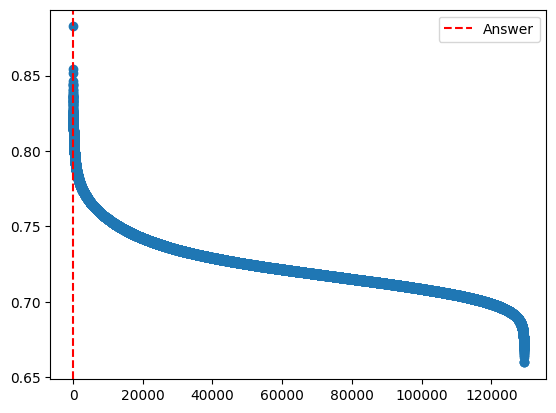

In [14]:
import matplotlib.pyplot as plt

sorted_df = graph.nodes_df.sort_values(by="similarity", ascending=False).reset_index(drop=True)

plt.scatter(
    range(len(sorted_df)),
    sorted_df["similarity"],
)

for i, row in sorted_df.iterrows():
    if row['is_answer']:
        plt.axvline(i, color='red', linestyle='--', label='Answer' if i == 0 else "")

plt.legend()
plt.show()